<a href="https://colab.research.google.com/github/Angga-Luri/some-try-code/blob/main/RestNet_for_Vehicle_Recognition_Modif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd '/content/gdrive/My Drive/UNUSIDA'

/content/gdrive/My Drive/UNUSIDA


In [ ]:
# ls

'Arsitektur & Organisasi Komputer.gslides'   dataset_resize/
 dataset/                                   'Pengantar T. Informatika.gslides'
 Dataset/


In [ ]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense,AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import datetime
import time
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import tensorflow as tf

print('Tensorflow_VER= V',tf.version.VERSION)
print(confusion_matrix)

Tensorflow_VER= V 2.12.0
<function confusion_matrix at 0x7f2e778b0160>


In [ ]:
train_data_dir = '/content/gdrive/My Drive/UNUSIDA/data_train/'
test_data_dir = '/content/gdrive/My Drive/UNUSIDA/data_test/'
validation_data_dir = '/content/gdrive/My Drive/UNUSIDA/data_val/'

#TUNING SEBAGIAN DISINI
batch_size = 16
lr=1e-4
opt='rmsprop'

In [ ]:
#Feature Extraction cuy
img_width, img_height = 224, 224

top_model_weights_path = 'vehicle_model.h5'

epochs = 100


resnet50 = applications.ResNet50(include_top=False, weights='imagenet')
resnet50.summary() #Arsitekturnya Wan

datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen = ImageDataGenerator(#rescale=1. / 255)
        rescale=1. / 255,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)
#

#Pre train Training
start = datetime.datetime.now()

train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode=None,
      shuffle=False)

nb_train_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

vehicle_features_train = resnet50.predict_generator(train_generator, predict_size_train)

np.save('/content/gdrive/My Drive/UNUSIDA/vehicle_features_train.npy', vehicle_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

<ipython-input-5-280ff8961ed7>:35: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vehicle_features_train = resnet50.predict_generator(train_generator, predict_size_train)


Time:  0:02:24.497413


In [ ]:
#Pre-train Validation cuy
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode=None,
      shuffle=False)

nb_validation_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

vehicle_features_validation = resnet50.predict_generator(
      generator, predict_size_validation)

np.save('/content/gdrive/My Drive/UNUSIDA/vehicle_features_validation.npy', vehicle_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 400 images belonging to 5 classes.


<ipython-input-6-17fb929b44b8>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vehicle_features_validation = resnet50.predict_generator(


Time:  0:01:19.779586


In [ ]:
#Pre train Testing
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
      test_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode=None,
      shuffle=False)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

vehicle_features_test = resnet50.predict_generator(
      generator, predict_size_test)

np.save('/content/gdrive/My Drive/UNUSIDA/vehicle_features_test.npy', vehicle_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 100 images belonging to 5 classes.


<ipython-input-7-7a02c8491bff>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vehicle_features_test = resnet50.predict_generator(


Time:  0:00:20.753232


In [ ]:
#TRAINING dan Testing
from sklearn.metrics import confusion_matrix
#TRAINING
#hasil= []
#resnet50 = applications.resnet50(include_top=False, weights='imagenet')
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [ ]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
img_width, img_height = 224, 224
top_model_weights_path = 'vehicle_model.h5'

datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
#training data
generator_top = datagen.flow_from_directory(
         train_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode='categorical',
         shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

train_data = np.load('/content/gdrive/My Drive/UNUSIDA/vehicle_features_train.npy')

train_labels = generator_top.classes

train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 400 images belonging to 5 classes.


In [ ]:
#testing data
generator_top = datagen.flow_from_directory(
         test_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('/content/gdrive/My Drive/UNUSIDA/vehicle_features_test.npy')


test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 100 images belonging to 5 classes.


In [ ]:
#Lanjut training
start = datetime.datetime.now()
model = Sequential()
#model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('/content/gdrive/My Drive/UNUSIDA/model/model_restnet50.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_data, train_labels,
      epochs=100,
      batch_size=batch_size,
      validation_data=(test_data, test_labels),
      verbose=0,
      callbacks=[es, mc])

model.save_weights(top_model_weights_path)


Epoch 1: val_acc improved from -inf to 0.41000, saving model to /content/gdrive/My Drive/UNUSIDA/model/model_restnet50.h5

Epoch 2: val_acc did not improve from 0.41000

Epoch 3: val_acc improved from 0.41000 to 0.68000, saving model to /content/gdrive/My Drive/UNUSIDA/model/model_restnet50.h5

Epoch 4: val_acc did not improve from 0.68000

Epoch 5: val_acc did not improve from 0.68000

Epoch 6: val_acc did not improve from 0.68000

Epoch 7: val_acc did not improve from 0.68000

Epoch 8: val_acc did not improve from 0.68000

Epoch 9: val_acc did not improve from 0.68000
Epoch 9: early stopping


In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(
 test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Time:  0:00:20.753232


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 501,765
Trainable params: 501,765
Non-trainable params: 0
_________________________________________________________________


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

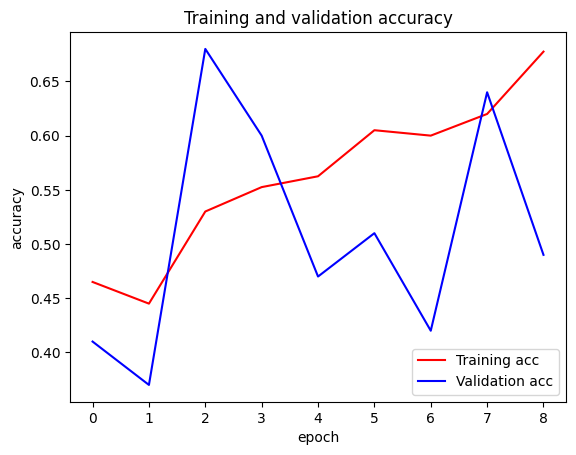

In [ ]:
plotacc = plt.figure(1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plotacc.show()
# plt.savefig("/content/gdrive/My Drive/UNUSIDA/image/resnet50/train/Acc_resnet50_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

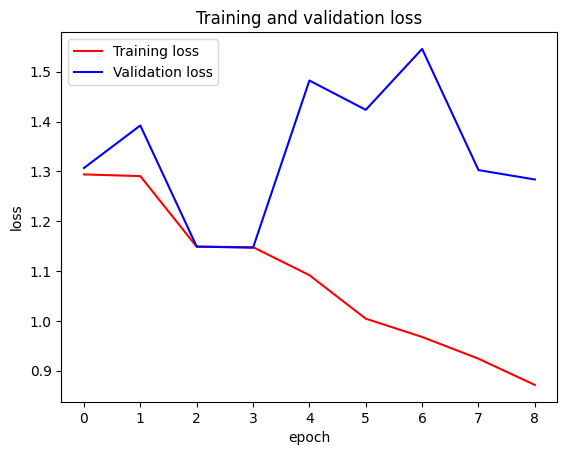

In [ ]:
plotloss = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plotloss.show()
# plt.savefig("/content/gdrive/My Drive/UNUSIDA/image/Loss_resnet50_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

In [ ]:
# plt.savefig("/content/gdrive/My Drive/UNUSIDA/image/resnet50/train/Acc_resnet50_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))
plt.savefig("/content/gdrive/My Drive/UNUSIDA/image/Loss_resnet50_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))



<Figure size 640x480 with 0 Axes>

In [ ]:
Evaluasi=model.evaluate(test_data, test_labels)
print(Evaluasi)

4/4 [==============================] - 0s 12ms/step - loss: 1.2837 - acc: 0.4900
[1.2836718559265137, 0.49000000953674316]


In [ ]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0)
score = model.predict(test_data)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)
#Model di save
model.save('/content/gdrive/My Drive/UNUSIDA/model/model_{}E.h5'.format(len(acc)))


test data [[[[0.         0.         0.         ... 2.4192948  0.
    0.        ]
   [0.         0.         0.         ... 1.7928115  0.
    0.        ]
   [0.         0.         0.         ... 1.4415127  0.
    0.        ]
   ...
   [0.         0.         0.         ... 1.6803014  0.
    0.        ]
   [0.         0.         0.         ... 1.541336   0.
    0.        ]
   [0.         0.         0.         ... 3.9173865  0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 2.156892   0.
    0.        ]
   [0.         0.         0.         ... 0.9544462  0.
    0.        ]
   ...
   [0.         0.         0.         ... 1.019299   0.
    0.        ]
   [0.         0.         0.         ... 3.5199633  0.
    0.        ]
   [0.         0.         0.         ... 2.2687626  0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.812350

In [ ]:
view = ['Golongan 1','Golongan 2','Golongan 3','Golongan 4','Golongan 5']

classification_metrics = metrics.classification_report(test_labels, preds, target_names=view )
print(classification_metrics)

              precision    recall  f1-score   support

  Golongan 1       0.90      0.95      0.93        20
  Golongan 2       0.00      0.00      0.00        20
  Golongan 3       0.56      0.50      0.53        20
  Golongan 4       0.58      0.70      0.64        20
  Golongan 5       0.00      0.00      0.00        20

   micro avg       0.66      0.43      0.52       100
   macro avg       0.41      0.43      0.42       100
weighted avg       0.41      0.43      0.42       100
 samples avg       0.43      0.43      0.43       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
print (categorical_test_labels)
print (categorical_preds)

0     0
1     0
2     0
3     0
4     0
     ..
95    4
96    4
97    4
98    4
99    4
Length: 100, dtype: int64
0     0
1     0
2     0
3     0
4     0
     ..
95    3
96    0
97    3
98    0
99    0
Length: 100, dtype: int64


Confusion matrix tanpa normalisasi 





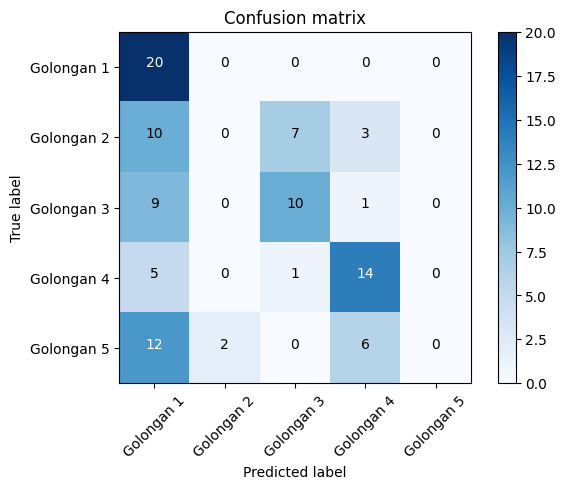

In [ ]:
plotcmnn = plt.figure(5)
plot_confusion_matrix(confusion_matrix, ['Golongan 1','Golongan 2','Golongan 3','Golongan 4','Golongan 5'])